In [1]:
import os
import numpy as np

from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import default_loader
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt


from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

from torchsummary import summary

In [2]:
class ImageWoof(ImageFolder):
    """
    Dataset class for ImageWoof dataset.
    """

    DATASET_URL = "https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-160.tgz"

    def __init__(
        self,
        root: str,
        img_size: int,
        transform=None,
        target_transform=None,
        loader=default_loader,
        is_valid_file=None,
        train=True,
    ):
        if os.path.exists(os.path.join(root, "imagewoof2-160")):
            root = os.path.join(root, "imagewoof2-160")
        elif os.path.exists(os.path.join(root, "imagewoof2-160.tgz")):
            os.system(f"tar zxvf {os.path.join(root, 'imagewoof2-160.tgz')}")
            root = os.path.join(root, "imagewoof2-160")
        else:
            download_url(self.DATASET_URL, ".")
            os.system(f"tar zxvf {os.path.join(root, 'imagewoof2-160.tgz')}")
            root = os.path.join(root, "imagewoof2-160")

        if train:
            root = os.path.join(root, "train")
        else:
            root = os.path.join(root, "val")

        if transform is None:
            transform = transforms.Compose(
                [
                    transforms.Resize((img_size, img_size)),
                    transforms.ToTensor(),
                ]
            )

        super().__init__(root, transform, target_transform, loader, is_valid_file)


In [234]:
#train and test data directory
train_data_dir = "./Dataset/train/"
val_data_dir = "./Dataset/val"

mean_train , std_train = torch.tensor([0.4861, 0.4560, 0.3940]) , torch.tensor([0.2531, 0.2460, 0.2549])
mean_val , std_val = torch.tensor([0.4903, 0.4595, 0.3982]) , torch.tensor([0.2507, 0.2437, 0.2524])



# #load the train and val data with Normalization
# train_dataset = ImageFolder(train_data_dir,transform = transforms.Compose([
#     transforms.Resize((150,150)),transforms.ToTensor(), transforms.Normalize(mean_train, std_train)
# ]))
# val_dataset = ImageFolder(val_data_dir,transforms.Compose([
#     transforms.Resize((150,150)),transforms.ToTensor(), transforms.Normalize(mean_val, std_val)
# ]))


#load the train and val data without Normalization
train_dataset = ImageFolder(train_data_dir,transform = transforms.Compose([
    transforms.Resize((160,160)),transforms.ToTensor()
#     , transforms.RandomHorizontalFlip(p=0.5),
]))
val_dataset = ImageFolder(val_data_dir,transforms.Compose([
    transforms.Resize((160,160)),transforms.ToTensor()
]))

In [235]:
train_dataset , val_dataset

(Dataset ImageFolder
     Number of datapoints: 9025
     Root location: ./Dataset/train/
     StandardTransform
 Transform: Compose(
                Resize(size=(160, 160), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 3929
     Root location: ./Dataset/val
     StandardTransform
 Transform: Compose(
                Resize(size=(160, 160), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ))

In [170]:
img, label = train_dataset[2000]
print(img.shape,label)

torch.Size([3, 160, 160]) 2


In [171]:
print("Follwing classes are there : \n",train_dataset.classes)

Follwing classes are there : 
 ['n02086240', 'n02087394', 'n02088364', 'n02089973', 'n02093754', 'n02096294', 'n02099601', 'n02105641', 'n02111889', 'n02115641']


In [172]:
def display_img(img,label):
    print(f"Label : {train_dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
for i in range(9000):
    if len(train_dataset[i][0]) == 1:
        print('Hi')
#     display_img(*train_dataset[66]
#     print()

KeyboardInterrupt: 

In [236]:
batch_size = 64
# val_ratio = 0.25
# val_size = int(val_ratio * len(dataset))
# train_size = int(len(dataset) - val_size)

# train_data,val_data = random_split(dataset,[train_size,val_size])

#load the train and validation into batches.
train_dl = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_dataset, batch_size, num_workers = 4, pin_memory = True)
# test_dl = DataLoader(test_dataset, batch_size, num_workers = 4, pin_memory = True)

# print(f"Length of Train Data : {len(train_dl)}")
# print(f"Length of Validation Data : {len(val_dl)}")
# print(f"Length of Testing Data : {len(test_data)}")


In [196]:
len(val_dl.dataset)

3929

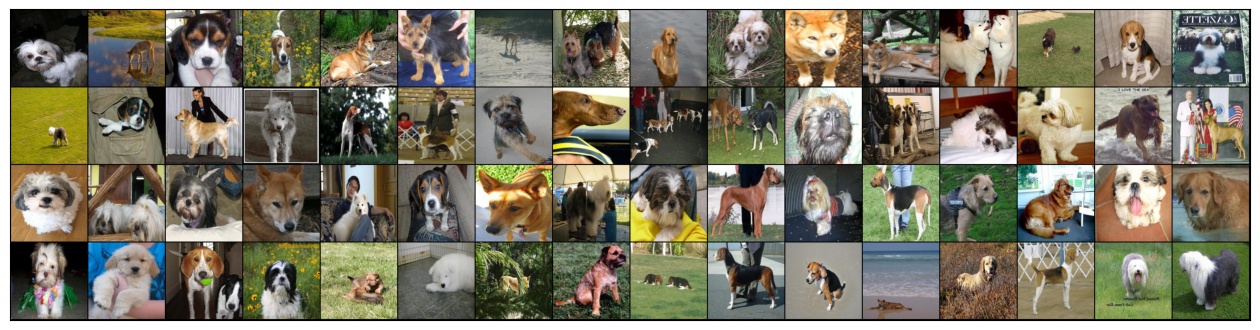

In [198]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

# Baseline Provided Model

In [257]:
import torch
from torch import nn


class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 8, 7, 1),
            nn.ReLU(),
            nn.Conv2d(8, 8, 7, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            #####
            nn.Conv2d(8, 16, 5, 1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 5, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            #####
            nn.Conv2d(16, 32, 3, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(
                output_size=8,
            ),
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 8 * 8, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        features = torch.flatten(features, start_dim=1)
        out = self.classifier(features)
        return out

    def num_of_params(self):
        total = 0
        for layer_params in self.feature_extractor.parameters():
            total += layer_params.numel()
        for layer_params in self.classifier.parameters():
            total += layer_params.numel()
        return total

#     def training_step(self, batch):
#         images, labels = batch 
#         out = self(images)                  # Generate predictions
#         loss = F.cross_entropy(out, labels) # Calculate loss
#         return loss
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss

        # Calculate training accuracy
        _, predicted = torch.max(out, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / labels.size(0)

        return {'loss': loss, 'accuracy': accuracy}
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_accuracy'] ,  result['val_loss'], result['val_acc']))

# Our Customized Model

In [288]:
import torch
from torch import nn


class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 16, 5, 1),
            nn.ReLU(),
            
            nn.MaxPool2d(3),
#             nn.BatchNorm2d(16),
#             nn.Dropout(0.2),
            nn.Conv2d(16, 32, 5, 1),
            nn.ReLU(),
            
            nn.MaxPool2d(3),
#             nn.BatchNorm2d(32),
#             nn.Dropout(0.2),
#             nn.Dropout(0.3),
            #####
#             nn.Conv2d(8, 16, 5, 1),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.MaxPool2d(2),
#             nn.Conv2d(16, 16, 5, 1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
            #####
#             nn.Conv2d(16, 32, 3, 1),
#             nn.ReLU(),
#             nn.Conv2d(32, 32, 3, 1),
#             nn.ReLU(),
            nn.AdaptiveAvgPool2d(
                output_size=8,
            ),
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 8 * 8, 1024),
            nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.ReLU(),
#             nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
#             nn.Dropout(0.2),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        features = torch.flatten(features, start_dim=1)
        out = self.classifier(features)
        return out

    def num_of_params(self):
        total = 0
        for layer_params in self.feature_extractor.parameters():
            total += layer_params.numel()
        for layer_params in self.classifier.parameters():
            total += layer_params.numel()
        return total

#     def training_step(self, batch):
#         images, labels = batch 
#         out = self(images)                  # Generate predictions
#         loss = F.cross_entropy(out, labels) # Calculate loss
#         return loss
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss

        # Calculate training accuracy
        _, predicted = torch.max(out, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / labels.size(0)

        return {'loss': loss, 'accuracy': accuracy}
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_accuracy'] ,  result['val_loss'], result['val_acc']))
        
        
model = CNN()

model.num_of_params()
to_device(model, device)
summary(model, (3, 160, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 156, 156]           1,216
              ReLU-2         [-1, 16, 156, 156]               0
         MaxPool2d-3           [-1, 16, 52, 52]               0
            Conv2d-4           [-1, 32, 48, 48]          12,832
              ReLU-5           [-1, 32, 48, 48]               0
         MaxPool2d-6           [-1, 32, 16, 16]               0
 AdaptiveAvgPool2d-7             [-1, 32, 8, 8]               0
            Linear-8                 [-1, 1024]       2,098,176
              ReLU-9                 [-1, 1024]               0
           Linear-10                  [-1, 512]         524,800
             ReLU-11                  [-1, 512]               0
           Linear-12                  [-1, 128]          65,664
             ReLU-13                  [-1, 128]               0
           Linear-14                   

## Final Model

In [289]:
import torch
from torch import nn


class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 16, 5, 1),
            nn.ReLU(),
            
            nn.MaxPool2d(3),
            nn.BatchNorm2d(16),
            nn.Dropout(0.2),
            nn.Conv2d(16, 32, 5, 1),
            nn.ReLU(),
            
            nn.MaxPool2d(3),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
#             nn.Dropout(0.3),
            #####
#             nn.Conv2d(8, 16, 5, 1),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.MaxPool2d(2),
#             nn.Conv2d(16, 16, 5, 1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
            #####
#             nn.Conv2d(16, 32, 3, 1),
#             nn.ReLU(),
#             nn.Conv2d(32, 32, 3, 1),
#             nn.ReLU(),
            nn.AdaptiveAvgPool2d(
                output_size=8,
            ),
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 8 * 8, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
#             nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        features = torch.flatten(features, start_dim=1)
        out = self.classifier(features)
        return out

    def num_of_params(self):
        total = 0
        for layer_params in self.feature_extractor.parameters():
            total += layer_params.numel()
        for layer_params in self.classifier.parameters():
            total += layer_params.numel()
        return total

#     def training_step(self, batch):
#         images, labels = batch 
#         out = self(images)                  # Generate predictions
#         loss = F.cross_entropy(out, labels) # Calculate loss
#         return loss
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss

        # Calculate training accuracy
        _, predicted = torch.max(out, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / labels.size(0)

        return {'loss': loss, 'accuracy': accuracy}
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_accuracy'] ,  result['val_loss'], result['val_acc']))

In [290]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True
                
early_stopping = EarlyStopping(tolerance=5, min_delta=0.010)


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr, momentum = 0.9) # SGD
#     optimizer = opt_func(model.parameters(), lr) # Adam
#     scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.33, total_iters=20)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=3, verbose=True)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.01)
#     scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
    
    best_val_accuracy = 0.0  # Initialize with the lowest possible accuracy
    best_model_weights = model.state_dict()  # Initialize with the current model weights

    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        train_accuracies = []  # List to store training accuracies
        
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            
            result = model.training_step(batch)
            loss = result['loss']
            accuracy = result['accuracy']
            
            train_losses.append(loss)
            train_accuracies.append(accuracy)
            
            loss.backward()
            optimizer.step()

        train_loss = torch.stack(train_losses).mean().item()
        train_accuracy = torch.tensor(train_accuracies).mean().item()
        
#         print("Accuracy: " , train_accuracy)
        
        with torch.no_grad():
            result = evaluate(model, val_loader)
            
        val_accuracy = result['val_acc']  # Assuming you're returning accuracy in your validation function
#         print("Validation Accuracy: " , val_accuracy)
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_weights = model.state_dict()
            
#         scheduler.step(result['val_loss'])
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}, Learning Rate: {current_lr}")
#         print("Hi , " , result)
        result['train_loss'] = train_loss
        result['train_accuracy'] = train_accuracy  # Store training accuracy
        model.epoch_end(epoch, result)
        history.append(result)
        
#         early_stopping(train_loss, result['val_loss'])
#         if early_stopping.early_stop:
#             print("We are at epoch:", epoch , "Hence, Early Stopping Applied.")
#             break
    # Save the best model weights to a file
    torch.save(best_model_weights, 'best_model_weights_Task_2.pth')
    
    return history

In [291]:
model = CNN()

model.num_of_params()

2704074

In [292]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()
device

device(type='cuda')

In [293]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [294]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [295]:
train_loader = DeviceDataLoader(train_dl, device)
val_loader = DeviceDataLoader(val_dl, device)

In [297]:
to_device(model, device)
summary(model, (3, 160, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 156, 156]           1,216
              ReLU-2         [-1, 16, 156, 156]               0
         MaxPool2d-3           [-1, 16, 52, 52]               0
       BatchNorm2d-4           [-1, 16, 52, 52]              32
           Dropout-5           [-1, 16, 52, 52]               0
            Conv2d-6           [-1, 32, 48, 48]          12,832
              ReLU-7           [-1, 32, 48, 48]               0
         MaxPool2d-8           [-1, 32, 16, 16]               0
       BatchNorm2d-9           [-1, 32, 16, 16]              64
          Dropout-10           [-1, 32, 16, 16]               0
AdaptiveAvgPool2d-11             [-1, 32, 8, 8]               0
           Linear-12                 [-1, 1024]       2,098,176
             ReLU-13                 [-1, 1024]               0
          Dropout-14                 [-

In [284]:
num_epochs = 30
opt_func = torch.optim.SGD
lr = 0.01#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

100%|█████████████████████████████████████████| 142/142 [00:05<00:00, 25.84it/s]


Epoch 1, Learning Rate: 0.01
Epoch [0], train_loss: 2.2979, train_acc: 0.1011, val_loss: 2.2928, val_acc: 0.1026


100%|█████████████████████████████████████████| 142/142 [00:05<00:00, 26.18it/s]


Epoch 2, Learning Rate: 0.01
Epoch [1], train_loss: 2.2985, train_acc: 0.1000, val_loss: 2.2915, val_acc: 0.1011


100%|█████████████████████████████████████████| 142/142 [00:05<00:00, 26.71it/s]


Epoch 3, Learning Rate: 0.01
Epoch [2], train_loss: 2.2951, train_acc: 0.1029, val_loss: 2.2914, val_acc: 0.1011


100%|█████████████████████████████████████████| 142/142 [00:05<00:00, 26.36it/s]


Epoch 4, Learning Rate: 0.01
Epoch [3], train_loss: 2.2950, train_acc: 0.1030, val_loss: 2.2908, val_acc: 0.1026


100%|█████████████████████████████████████████| 142/142 [00:05<00:00, 25.69it/s]


KeyboardInterrupt: 

## Our Own Model Graphs

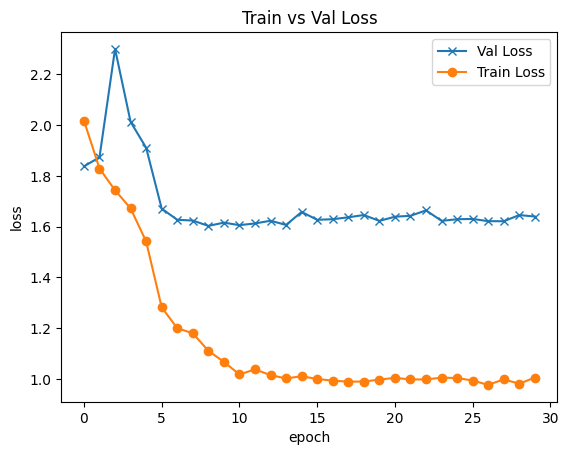

In [159]:
losses_val = [x['val_loss'] for x in history]
losses_train = [x['train_loss'] for x in history]
plt.plot(losses_val, '-x', label ='Val Loss' )
plt.plot(losses_train, '-o', label ='Train Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train vs Val Loss')
plt.legend()

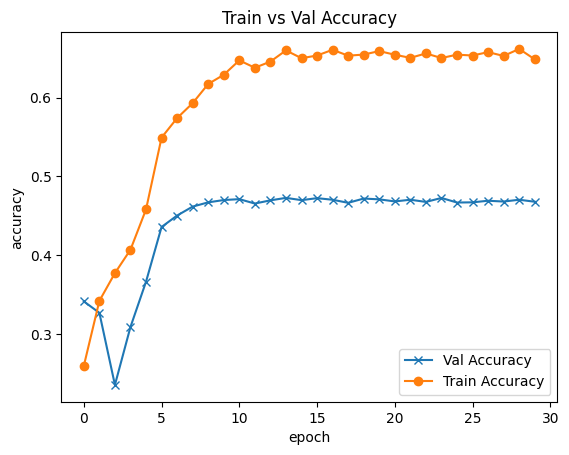

In [160]:
val_accuracies = [x['val_acc'] for x in history]
train_accuracies = [x['train_accuracy'] for x in history]
plt.plot(val_accuracies, '-x' , label ='Val Accuracy')
plt.plot(train_accuracies, '-o', label ='Train Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train vs Val Accuracy')
plt.legend()

In [ ]:
# Epoch 30 Results
# Epoch [27], train_loss: 0.6428, train_acc: 0.7790, val_loss: 1.7451, val_acc: 0.4862

# Batch Size 4 -> 336 Seconds

# Batch Size 64 -> 

# Batch Size 512 -> 150 Seconds
# Epoch [25], train_loss: 1.0071, train_acc: 0.6550, val_loss: 1.8357, val_acc: 0.4137

In [186]:
import pickle
with open('./Task 2/Task 2.4/Model 2.4.4-RHF-0.25', 'wb') as file_pi:
    pickle.dump(history, file_pi)

In [209]:
total_files = os.listdir('./Task 1.3/')
total_files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
total_files

['Model 1.3.1',
 'Model 1.3.2',
 'Model 1.3.3',
 'Model 1.3.4',
 'Model 1.3.5',
 'Model 1.3.6']

In [210]:
history_all = []
for i in range(len(total_files)):
    with open(f'./Task 1.3/{total_files[i]}', "rb") as file_pi:
        history_new = pickle.load(file_pi)
        history_all.append(history_new)
    
history_all

[[{'val_loss': 2.4911420345306396,
   'val_acc': 0.1025705635547638,
   'train_loss': 2.2590670585632324,
   'train_accuracy': 0.1296214759349823},
  {'val_loss': 2.2686917781829834,
   'val_acc': 0.13256047666072845,
   'train_loss': 2.2968337535858154,
   'train_accuracy': 0.11586707830429077},
  {'val_loss': 2.145890712738037,
   'val_acc': 0.1864919364452362,
   'train_loss': 2.25873064994812,
   'train_accuracy': 0.13985475897789001},
  {'val_loss': 2.051999807357788,
   'val_acc': 0.2239616960287094,
   'train_loss': 2.1159608364105225,
   'train_accuracy': 0.19575263559818268},
  {'val_loss': 2.235934257507324,
   'val_acc': 0.18184475600719452,
   'train_loss': 2.056425094604492,
   'train_accuracy': 0.22029049694538116},
  {'val_loss': 2.0230088233947754,
   'val_acc': 0.23511087894439697,
   'train_loss': 2.020927906036377,
   'train_accuracy': 0.23844631016254425},
  {'val_loss': 2.0118627548217773,
   'val_acc': 0.23818548023700714,
   'train_loss': 2.016009569168091,
   't

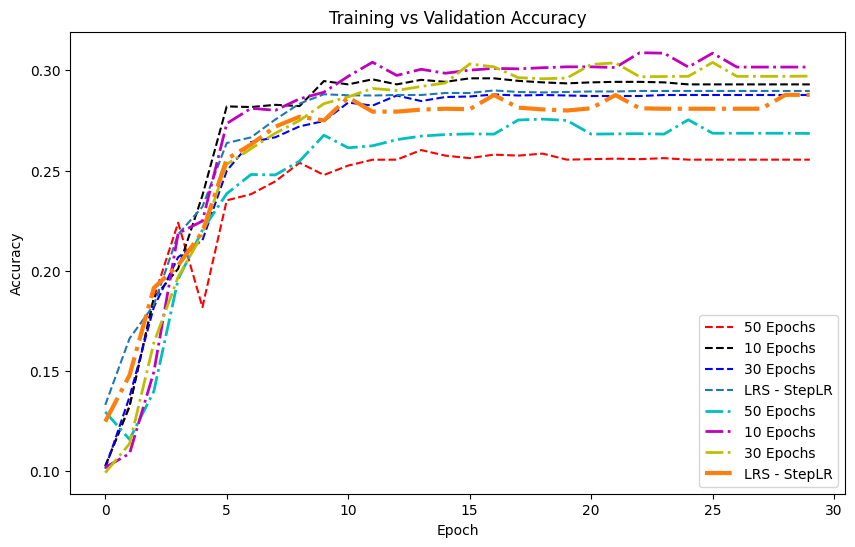

In [211]:
# Task 1.4
plt.figure(figsize=(10,6))

plt.plot([x['val_acc'] for x in history_all[0]], linestyle='dashed' , label ='50 Epochs', color='r')
plt.plot([x['val_acc'] for x in history_all[1]], linestyle='dashed' , label ='10 Epochs', color='k')
plt.plot([x['val_acc'] for x in history_all[2]], linestyle='dashed' , label ='30 Epochs', color='b')
plt.plot([x['val_acc'] for x in history_all[3]], linestyle='dashed' , label ='LRS - StepLR')

plt.plot([x['train_accuracy'] for x in history_all[0]], linestyle='-.' , linewidth=2, label ='50 Epochs', color='c')
plt.plot([x['train_accuracy'] for x in history_all[1]], linestyle='-.' , linewidth=2, label ='10 Epochs', color='m')
plt.plot([x['train_accuracy'] for x in history_all[2]], linestyle='-.' , linewidth=2, label ='30 Epochs', color='y')
plt.plot([x['train_accuracy'] for x in history_all[3]], linestyle='-.' , linewidth=3, label ='LRS - StepLR')


# Task 1.4
# plt.figure(figsize=(10,6))

# # plt.plot([x['val_acc'] for x in history_all[1]], linestyle='dashed' , label ='Without RHF')
# plt.plot([x['val_acc'] for x in history_all[3]], linestyle='dashed' , label ='With RHF - 0.25')
# plt.plot([x['val_acc'] for x in history_all[0]], linestyle='dashed' , label ='With RHF - 0.5')
# plt.plot([x['val_acc'] for x in history_all[2]], linestyle='dashed' , label ='With RHF - 0.85')


# # plt.plot([x['train_accuracy'] for x in history_all[1]], linestyle='-.' , linewidth=3, label ='Without RHF')
# plt.plot([x['train_accuracy'] for x in history_all[3]], linestyle='-.' , linewidth=3, label ='With RHF - 0.25')
# plt.plot([x['train_accuracy'] for x in history_all[0]], linestyle='-.' , linewidth=3, label ='With RHF - 0.5')
# plt.plot([x['train_accuracy'] for x in history_all[2]], linestyle='-.' , linewidth=3, label ='With RHF - 0.85')



plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()


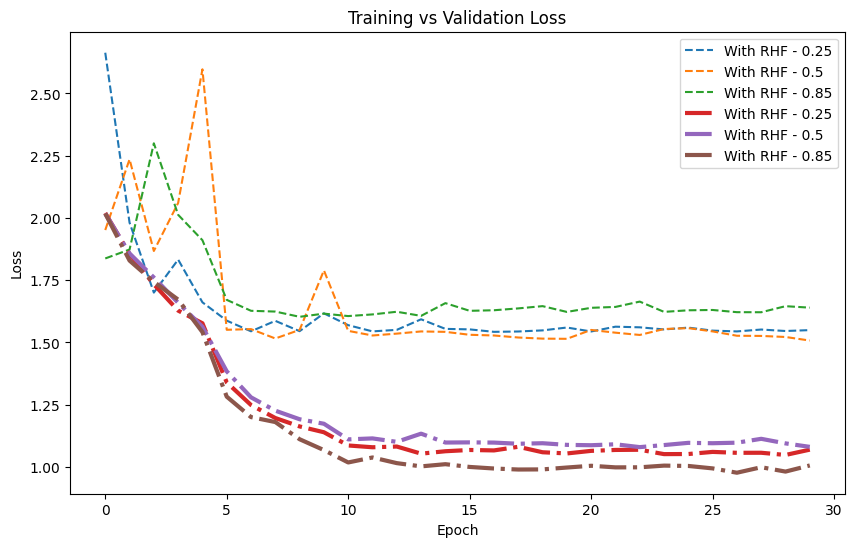

In [192]:
plt.figure(figsize=(10,6))

# plt.plot([x['val_loss'] for x in history_all[0]], linestyle='dashed' , label ='50 Epochs', color='r')
# plt.plot([x['val_loss'] for x in history_all[1]], linestyle='dashed' , label ='10 Epochs', color='k')
# plt.plot([x['val_loss'] for x in history_all[2]], linestyle='dashed' , label ='30 Epochs', color='b')
# # plt.plot([x['val_acc'] for x in history_all[3]], linestyle='dashed' , label ='LRS - StepLR')

# plt.plot([x['train_loss'] for x in history_all[0]], linestyle='-.' , linewidth=2, label ='50 Epochs', color='c')
# plt.plot([x['train_loss'] for x in history_all[1]], linestyle='-.' , linewidth=2, label ='10 Epochs', color='m')
# plt.plot([x['train_loss'] for x in history_all[2]], linestyle='-.' , linewidth=2, label ='30 Epochs', color='y')

# plt.plot([x['val_acc'] for x in history_all[1]], linestyle='dashed' , label ='Without RHF')
plt.plot([x['val_loss'] for x in history_all[3]], linestyle='dashed' , label ='With RHF - 0.25')
plt.plot([x['val_loss'] for x in history_all[0]], linestyle='dashed' , label ='With RHF - 0.5')
plt.plot([x['val_loss'] for x in history_all[2]], linestyle='dashed' , label ='With RHF - 0.85')


# plt.plot([x['train_accuracy'] for x in history_all[1]], linestyle='-.' , linewidth=3, label ='Without RHF')
plt.plot([x['train_loss'] for x in history_all[3]], linestyle='-.' , linewidth=3, label ='With RHF - 0.25')
plt.plot([x['train_loss'] for x in history_all[0]], linestyle='-.' , linewidth=3, label ='With RHF - 0.5')
plt.plot([x['train_loss'] for x in history_all[2]], linestyle='-.' , linewidth=3, label ='With RHF - 0.85')


# plt.plot(history_all, '-o', label ='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()